In [1]:

import argparse
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abcclassify.abcclassify as abcc
import csv
import os.path
from sklearn import tree
import copy


In [2]:

#participant = abcc.videotracking(framerange=(10530, 15611))
participant = abcc.videotracking(framerange=(5030, 15611))
participant.addtrackingdata("/home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface")
groundtruth = abcc.loadExternalGroundTruth("/home/zzalsdme/IDInteraction/paper/results/Groundtruth/P01_attention.csv", \
                                           participant)
# All the potential training frames
trainingframes = participant.frames
np.random.shuffle(trainingframes)
participant.setClassificationMethod("random")
cvfolds = 5

randparticipant = copy.deepcopy(participant)
randtrainingframes = trainingframes[:]

Loading tracking data from: /home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface
OpenFace input detected


We want to explore different approaches to training the classifier.  We've already looked at sequential and random, and shown that random classification leads to much better performance.  

Rob suggested looking at areas that had poor performance, and focussing on these.  If we've got ground truth we *know* where has poor performance. Normally though we'll need to use cross validation to estimate the performance of the classifier


We want a window size such that the cross-validation scores are resonably stable.



In [3]:
batchsize = 20
windowsize = 500 # Number of (total - classified and unclassified) frames in each window
advancesize = 100  # The amount to advance each window by
# overlap between adjacent windows will be windowsize - advancesize

def trainRegion(participant, groundtruth):
    """Apply the groundtruth data to a participant"""
    for index,row in groundtruth.iterrows():
        #print "setting classification for" + str(index) + ":" + str(row["state"])
        participant.setClassification(index, row["state"], testunset = True)
        

def calcWindowedAccuracy(participant, windowsize, advancesize):
    """Test the xval accuracy of overlapping windows within the object"""
    firstframe = min(participant.frames)
    lastframe = max(participant.frames)

    windowstarts = range(firstframe, lastframe - windowsize, advancesize)

    means=[]
    stds = []
    numframes = []
    for fr in windowstarts:
        thispart = participant.split((fr, fr + windowsize))
        try: 
            thispartvtc = abcc.videotrackingclassifier(thispart)
            xvalscore = thispartvtc.getCrossValidatedScore(cv = cvfolds)
        except ValueError:
            xvalscore = np.array([np.NaN])
        means.append(xvalscore.mean())
        stds.append(xvalscore.std())
        numframes.append(len(thispart.getClassifiedFrames()))
    
    results = pd.DataFrame.from_items([("startframe", windowstarts),
                                  ("mean", means),
                                  ("std", stds),
                                  ("numclassframes", numframes)])
    
    return results


# Perform initial training with batchsize frames
initialbatchsize = 4*batchsize
trainRegion(participant, groundtruth.loc[trainingframes[:initialbatchsize]])
trainRegion(randparticipant, groundtruth.loc[randtrainingframes[:initialbatchsize]])
randtrainingframes = randtrainingframes[initialbatchsize:]

results = pd.DataFrame(columns=["startframe", "classifiedframes", "mean", "std"])    
for i in range(0,30):
    batchresults = calcWindowedAccuracy(participant, windowsize, advancesize)
    #print results
    
    # Find the minimum accuracy startframe
    # TODO - handle tiebreaks - pick at random
    minstartframe = batchresults["startframe"].iloc[np.nanargmin(batchresults["mean"])]
    
    # Get frames we to classify in this range
    trainrange = range(minstartframe, minstartframe + windowsize)
    if max(trainrange) > max(participant.gettrackableframes()):
        print "Warning - training range extends beyond trackable region"
    trainingframes = list(set(trainrange) - \
                      set(participant.getClassifiedFrames().index))
    if len(trainingframes) < batchsize:
        print "Warning - classifying all frames at " + str(minstartframe)
    np.random.shuffle(trainingframes)
    trainingframes = trainingframes[:batchsize]
    traindata = groundtruth.loc[trainingframes]
    trainRegion(participant, traindata)

    vtc = abcc.videotrackingclassifier(participant)
    xvalscore = vtc.getCrossValidatedScore(cv=cvfolds)
    
    
    # And train the same number of frames at random
    randbatch = randtrainingframes[:len(trainingframes)]
    randtrainingframes = randtrainingframes[len(trainingframes):]
    trainRegion(randparticipant, groundtruth.loc[randbatch])
    rvtc = abcc.videotrackingclassifier(randparticipant)
    rxvalscore = rvtc.getCrossValidatedScore(cv=cvfolds)
    
    if vtc.vto.numClassifiedFrames() != rvtc.vto.numClassifiedFrames():
        raise ValueError("Number of classified frames is out of sync")
    
    results = results.append({"startframe":minstartframe, 
                   "classifiedframes":vtc.vto.numClassifiedFrames(),
                   "mean":xvalscore.mean(),
                   "std": xvalscore.std(),
                   "randmean": rxvalscore.mean(),
                   "randstd" : rxvalscore.std(),
                   "batchsize": len(trainingframes)    
                    }, ignore_index=True)
    
print results

      
    
    



    startframe  classifiedframes      mean       std  batchsize  randmean  \
0         7430               100  0.810000  0.080000         20  0.820000   
1         7230               120  0.875000  0.069722         20  0.900000   
2         9530               140  0.864286  0.034993         20  0.928571   
3         9030               160  0.856250  0.046771         20  0.900000   
4        12130               180  0.900000  0.041574         20  0.922222   
5        11830               200  0.845000  0.024495         20  0.875000   
6         6830               220  0.845455  0.063311         20  0.872727   
7         9930               240  0.841667  0.036324         20  0.883333   
8         6130               260  0.888462  0.018842         20  0.892308   
9        11430               280  0.882143  0.058248         20  0.889286   
10       11030               300  0.863333  0.019437         20  0.916667   
11       10230               320  0.825000  0.038780         20  0.878125   

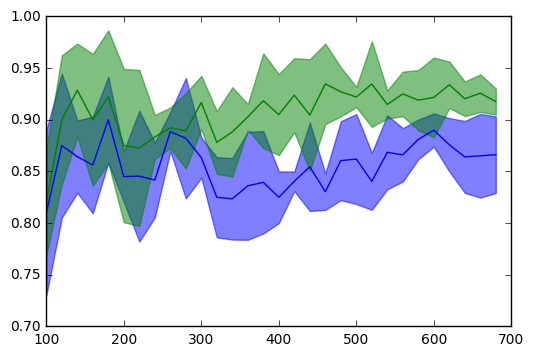

In [4]:
plt.fill_between(results["classifiedframes"], \
            results["mean"] - results["std"], results["mean"] + results["std"], \
                 alpha = 0.5, color="blue")

plt.fill_between(results["classifiedframes"], results["randmean"] - results["randstd"], \
                 results["randmean"] + results["randstd"], alpha = 0.5, color="green")

plt.plot(results["classifiedframes"], results["mean"], color="blue")
plt.plot(results["classifiedframes"], results["randmean"], color="green")
plt.show()

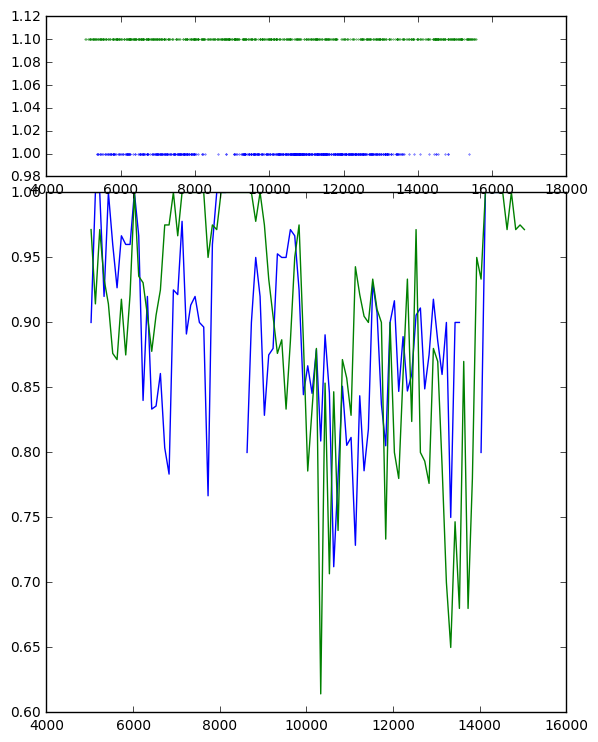

In [5]:
# Get the windowed accuracy for the randomly classified data
randbatchresults = calcWindowedAccuracy(randparticipant, windowsize, advancesize)

# Figure modified from
# https://matplotlib.org/examples/pylab_examples/scatter_hist.html

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_main = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]


# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axMain = plt.axes(rect_main)
axHistx = plt.axes(rect_histx)
#axHisty = plt.axes(rect_histy)


axMain.plot(batchresults["startframe"], batchresults["mean"], color="blue")
axMain.plot(randbatchresults["startframe"], randbatchresults["mean"], color="green")
cframes = list(participant.getClassifiedFrames().index)
axHistx.scatter(cframes, [1] * len(cframes), s=.1, color="blue")
rcframes = list(randparticipant.getClassifiedFrames().index)
axHistx.scatter(rcframes, [1.1] * len(rcframes), s=.1, color="green")
plt.show()




# Find the minimum startframe
minstartframe = results["startframe"].iloc[results["mean"].argmin()]

# Get frames we to classify in this range
trainingframes = list(set(range(minstartframe, minstartframe + windowsize)) - \
                      set(participant.getClassifiedFrames().index))
print len(trainingframes)
np.random.shuffle(trainingframes)

